In [1]:
# Collect metadata of the dataset(s)

!apt-get install openjdk-11-jdk-headless -qq > /dev/null # installing java
!curl -L -o spark-3.4.1-bin-hadoop3.tgz https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz # downloading Spark from Apache
!tar -xzf spark-3.4.1-bin-hadoop3.tgz # initializing spark
!pip install -q findspark # get findspark

import os
import findspark
from google.colab import files

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

findspark.init()
uploaded = files.upload() # getting files (should be saved to google drive or local folder)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  370M  100  370M    0     0  2070k      0  0:03:03  0:03:03 --:--:-- 19.5M


Saving winequality-red.csv to winequality-red.csv
Saving winequality-white.csv to winequality-white.csv


In [2]:
# REQUIRED to use Spark MLlib

spark = SparkSession.builder.appName("WineQualityAnalysis").getOrCreate()

# method each wine calls
def analyze_wine(file_path, wine_type):
    print(f"\n{'-----'} {wine_type} WINE {'-----'}")

    # getting dataset
    df = spark.read.csv(file_path, header=True, inferSchema=True, sep=';')
    # df.printSchema()
    df.describe().show()

    # checking correlation between alc content & wine quality
    corr = df.stat.corr("alcohol", "quality")
    print(f"\nCorrelation between alcohol and quality: {corr:.3f}")

    # combine features
    feature_cols = df.columns[:-1]  # -1 to exclude 'quality' (last col)
    vecTrainDF = VectorAssembler(inputCols=feature_cols, outputCol="features")
    selectedDF = vecTrainDF.transform(df).select("features", "quality")

    # training data
    trainDF, testDF = selectedDF.randomSplit([0.8, 0.2], seed=42)
    linearRegression = LinearRegression(labelCol="quality")
    model = linearRegression.fit(trainDF)

    # apply model to test data
    predDF = model.transform(testDF)

    regressionEvaluator = RegressionEvaluator(
        labelCol="quality",
        predictionCol="prediction",
        metricName="rmse"
    )
    rmse = regressionEvaluator.evaluate(predDF)

    summary = model.evaluate(testDF)
    print(f"The RMSE value is = {rmse:.4f}")
    print(f"RMSE (via model summary): {summary.rootMeanSquaredError:.4f}")

    # importances
    print("\nFeature Coefficients:")
    for name, coef in zip(feature_cols, model.coefficients):
        print(f"{name}: {coef:.4f}")

# analysis for both wine datasets
analyze_wine("winequality-red.csv", "RED")
analyze_wine("winequality-white.csv", "WHITE")


----- RED WINE -----
+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+
|summary|     fixed acidity|   volatile acidity|        citric acid|    residual sugar|           chlorides|free sulfur dioxide|total sulfur dioxide|             density|                 pH|         sulphates|           alcohol|           quality|
+-------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+
|  count|              1599|               1599|               1599|              1599|                1599|               1599|                1599|                1599|               1599|              1599|              1599|      

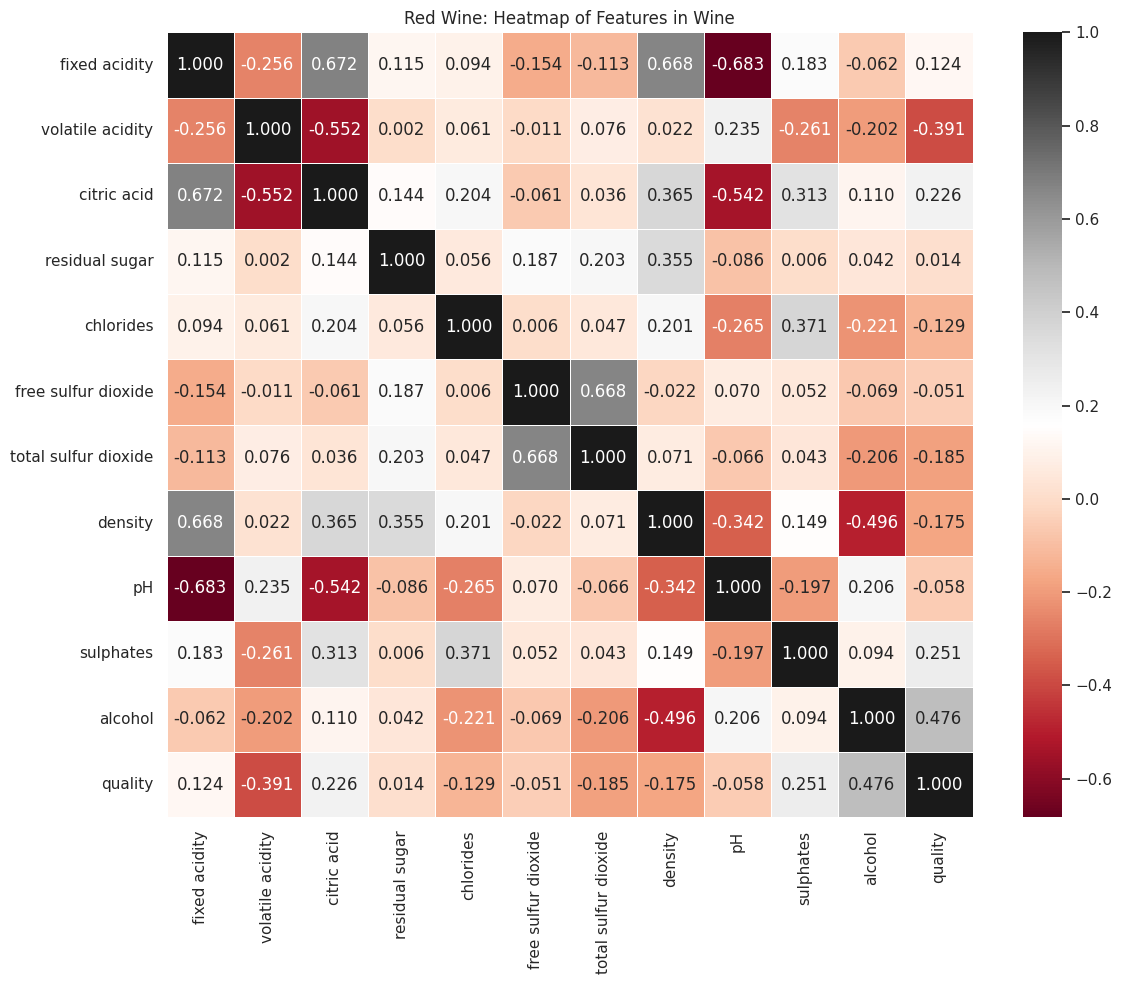

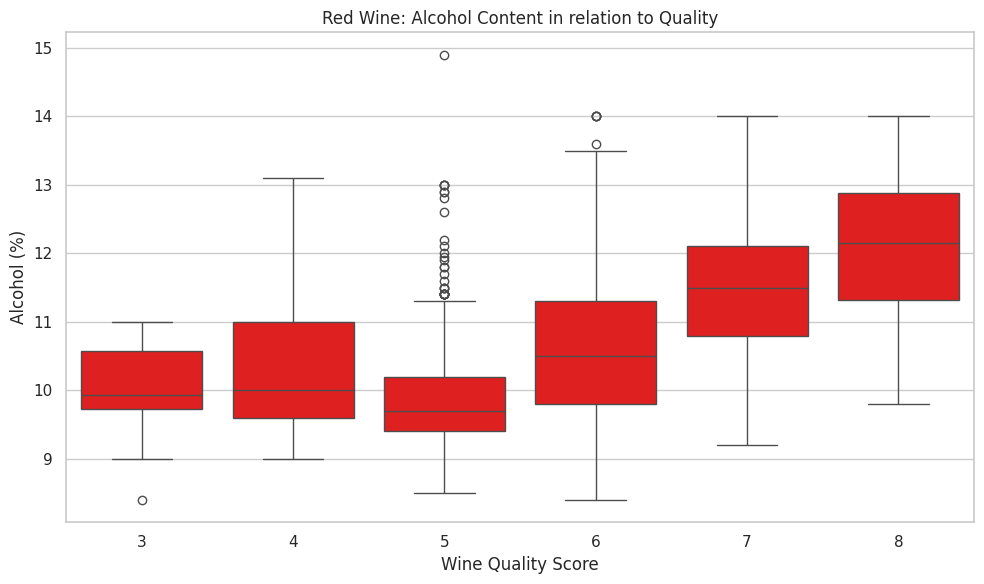

In [3]:
# Visualize the data (at least TWO types of nontrivial plots)
# plots for red wine

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("winequality-red.csv", sep=';')
sns.set(style="whitegrid")

# plot 1
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdGy', fmt=".3f", linewidths=0.5)
plt.title("Red Wine: Heatmap of Features in Wine")
plt.tight_layout()
plt.savefig("correlation_heatmap_red.png")
plt.show()

# plot 2
plt.figure(figsize=(10, 6))
sns.boxplot(x="quality", y="alcohol", data=df, color="red")
plt.title("Red Wine: Alcohol Content in relation to Quality")
plt.xlabel("Wine Quality Score")
plt.ylabel("Alcohol (%)")
plt.tight_layout()
plt.savefig("alc_qual_boxplot_red.png")
plt.show()

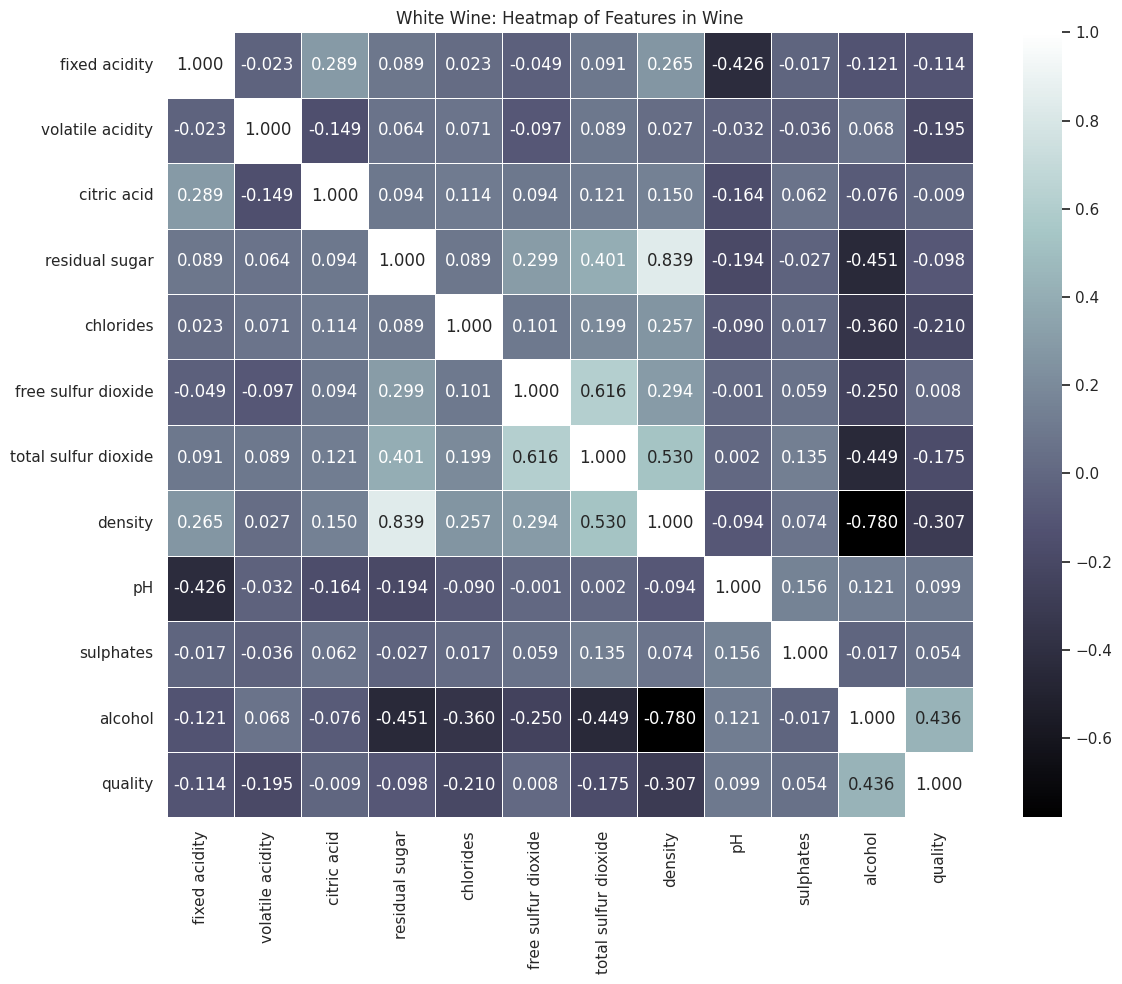

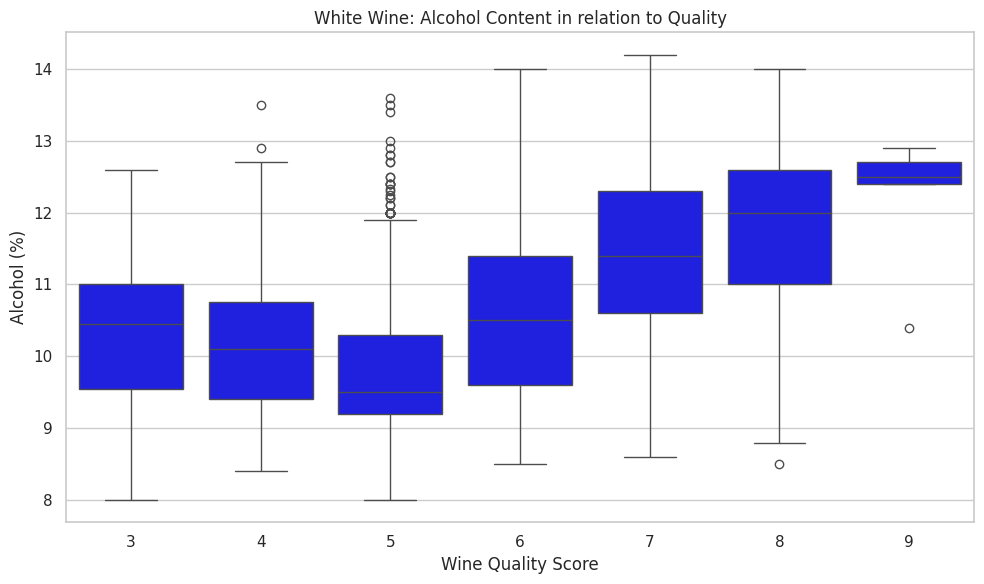

In [4]:
# plots for white wine

df = pd.read_csv("winequality-white.csv", sep=';')
sns.set(style="whitegrid")

# plot 1
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='bone', fmt=".3f", linewidths=0.5)
plt.title("White Wine: Heatmap of Features in Wine")
plt.tight_layout()
plt.savefig("correlation_heatmap_white.png")
plt.show()

# plot 2
plt.figure(figsize=(10, 6))
sns.boxplot(x="quality", y="alcohol", data=df, color="blue")
plt.title("White Wine: Alcohol Content in relation to Quality")
plt.xlabel("Wine Quality Score")
plt.ylabel("Alcohol (%)")
plt.tight_layout()
plt.savefig("alc_qual_boxplot_white.png")
plt.show()
